In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import tensorflow as tf
import numpy as np
import  matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import pandas as pd
import time
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.io import savemat,loadmat
import warnings
warnings.filterwarnings("ignore")

D:\Compiler_Environment\Python\Anconda\envs\base64\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
dataset = pd.read_excel("816480.xlsx")
fratures_Corrected_irradiance = [
    'Flow (Veh/5 Minutes)'
]
values = dataset[fratures_Corrected_irradiance].values
n_features=1 #特征数量

In [5]:
# 标准化
scaler =StandardScaler()
scaled = scaler.fit_transform(values)

In [6]:
n_in = 3
n_out = 1
# 构造一个20->1的监督学习型数据
reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
values=reframed.values

In [7]:
#训练集和测试集的划分比例
ratio=0.8 
N=int(len(values) *ratio)
train = values[:N, :]
test = values[N:, :]

In [8]:

    # 划分输入和输出,split into input and outputs
    n_obs = n_in * n_features
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1149, 3) (1149,) (288, 3) (288,)


In [9]:
    train_y=train_y.reshape(-1,1)
    train_X=train_X.reshape(-1,3,1)
    test_X=test_X.reshape(-1,3,1)

In [14]:
prediction_test = []
actual_test = []
#import lightgbm as lgb
import argparse
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
from sklearn.model_selection import train_test_split
from data_loader import TSFDataLoader  # You may need to adapt this import
import models  # You may need to adapt this import
from models import tsmixer

In [16]:

    build_model = tsmixer.build_model
    model = build_model(
        input_shape=(3, 1),
        pred_len=1,
        norm_type= 'B',
        activation= 'relu',
        dropout= 0.05,
        n_block=2,
        ff_dim=2048,
        target_slice=0,
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath='.ctsmixer',
      verbose=1,
      save_best_only=True,
      save_weights_only=True,
    )
    early_stop_callback = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=5
    )
    start_training_time = time.time()
    history = model.fit(
      train_X,train_y,
      epochs=100,
      validation_data=(test_X,test_y),
      callbacks=[checkpoint_callback, early_stop_callback],
    )

    # evaluate best model
    best_epoch = np.argmin(history.history['val_loss'])
    model.load_weights('.ctsmixer')
    #预测
    yhat = model.predict(test_X)
    yhat=yhat.reshape(-1,1)
    # 对预测结果进行反归一化
    inv_yhat = scaler.inverse_transform(yhat)
    prediction_test.append(inv_yhat)
    # 将真实列据进行反归一化
    test_y=test_y.reshape(-1,1)
    inv_y = scaler.inverse_transform(test_y)
    actual_test.append(inv_y)

Epoch 1/100
31/36 [========================>.....] - ETA: 0s - loss: 0.8241 - mae: 0.6968
Epoch 1: val_loss improved from inf to 0.77161, saving model to .ctsmixer
36/36 [==============================] - 3s 17ms/step - loss: 0.8246 - mae: 0.6966 - val_loss: 0.7716 - val_mae: 0.6983
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 0.5555 - mae: 0.5724
Epoch 2: val_loss did not improve from 0.77161
36/36 [==============================] - 0s 9ms/step - loss: 0.5555 - mae: 0.5724 - val_loss: 1.4107 - val_mae: 0.8805
Epoch 3/100
30/36 [========================>.....] - ETA: 0s - loss: 0.3853 - mae: 0.4824
Epoch 3: val_loss improved from 0.77161 to 0.75300, saving model to .ctsmixer
36/36 [==============================] - 0s 10ms/step - loss: 0.3963 - mae: 0.4906 - val_loss: 0.7530 - val_mae: 0.6557
Epoch 4/100
35/36 [============================>.] - ETA: 0s - loss: 0.3556 - mae: 0.4578
Epoch 4: val_loss improved from 0.75300 to 0.46071, saving model to .ctsmixer
36/3

In [17]:
mean_pre_test = []                    

for i in range(0,len(prediction_test[0])):
    sum = 0
    for j in range(0,len(prediction_test)):
        sum = sum + prediction_test[j][i]
    
#     mean = sum/len(prediction_test) 
    mean_pre_test.append(sum)
        
mean_pre_test  

[array([145.11603], dtype=float32),
 array([124.30672], dtype=float32),
 array([116.25615], dtype=float32),
 array([104.14229], dtype=float32),
 array([188.83292], dtype=float32),
 array([149.81842], dtype=float32),
 array([121.87549], dtype=float32),
 array([118.80138], dtype=float32),
 array([121.2316], dtype=float32),
 array([130.6901], dtype=float32),
 array([144.19434], dtype=float32),
 array([102.82135], dtype=float32),
 array([115.95836], dtype=float32),
 array([97.91286], dtype=float32),
 array([102.14867], dtype=float32),
 array([93.41821], dtype=float32),
 array([112.92029], dtype=float32),
 array([117.20398], dtype=float32),
 array([91.29242], dtype=float32),
 array([98.64888], dtype=float32),
 array([86.43565], dtype=float32),
 array([92.42125], dtype=float32),
 array([90.56944], dtype=float32),
 array([97.50189], dtype=float32),
 array([74.64525], dtype=float32),
 array([98.315414], dtype=float32),
 array([86.15022], dtype=float32),
 array([96.70073], dtype=float32),
 arra

In [18]:
mean_actual_test = []

for i in range(0,len(actual_test[0])):
    sum = 0
    for j in range(0,len(actual_test)):
        sum = sum + actual_test[j][i]
    
#     mean = sum/len(actual_test)
    mean_actual_test.append(sum)
        
mean_actual_test  

[array([114.]),
 array([105.]),
 array([91.]),
 array([176.]),
 array([141.]),
 array([111.]),
 array([108.]),
 array([111.]),
 array([122.]),
 array([136.]),
 array([89.]),
 array([105.]),
 array([84.]),
 array([89.]),
 array([79.]),
 array([102.]),
 array([107.]),
 array([76.]),
 array([85.]),
 array([71.]),
 array([78.]),
 array([76.]),
 array([84.]),
 array([57.]),
 array([85.]),
 array([71.]),
 array([83.]),
 array([61.]),
 array([61.]),
 array([65.]),
 array([67.]),
 array([83.]),
 array([70.]),
 array([53.]),
 array([72.]),
 array([71.]),
 array([52.]),
 array([59.]),
 array([57.]),
 array([57.]),
 array([78.]),
 array([75.]),
 array([85.]),
 array([109.]),
 array([106.]),
 array([119.]),
 array([131.]),
 array([112.]),
 array([81.]),
 array([87.]),
 array([106.]),
 array([104.]),
 array([113.]),
 array([87.]),
 array([166.]),
 array([152.]),
 array([185.]),
 array([200.]),
 array([203.]),
 array([150.]),
 array([154.]),
 array([131.]),
 array([162.]),
 array([209.]),
 array([22

In [19]:
# 计算RMSE
def mape(y_true, y_pred):
    #评价指标MAPE
    record=[]
    for index in range(len(y_true)):
        if abs(y_true[index])>10:
            temp_mape=np.abs((y_pred[index] - y_true[index]) / y_true[index])
            record.append(temp_mape)
    return np.mean(record) * 100
rmse = sqrt(mean_squared_error(mean_actual_test, mean_pre_test))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(mean_actual_test, mean_pre_test))
print('Test MAPE: %.7f' % mape(mean_actual_test, mean_pre_test))
print('Test R2: %.7f' % r2_score(mean_actual_test, mean_pre_test))

Test RMSE: 37.1921695
Test MAE: 28.5123132
Test MAPE: 10.7353613
Test R2: 0.9480625


In [15]:
# 计算RMSE
def mape(y_true, y_pred):
    #评价指标MAPE
    record=[]
    for index in range(len(y_true)):
        if abs(y_true[index])>10:
            temp_mape=np.abs((y_pred[index] - y_true[index]) / y_true[index])
            record.append(temp_mape)
    return np.mean(record) * 100
rmse = sqrt(mean_squared_error(mean_actual_test, mean_pre_test))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(mean_actual_test, mean_pre_test))
print('Test MAPE: %.7f' % mape(mean_actual_test, mean_pre_test))
print('Test R2: %.7f' % r2_score(mean_actual_test, mean_pre_test))

Test RMSE: 41.4160038
Test MAE: 34.5864783
Test MAPE: 14.0743415
Test R2: 0.9355958


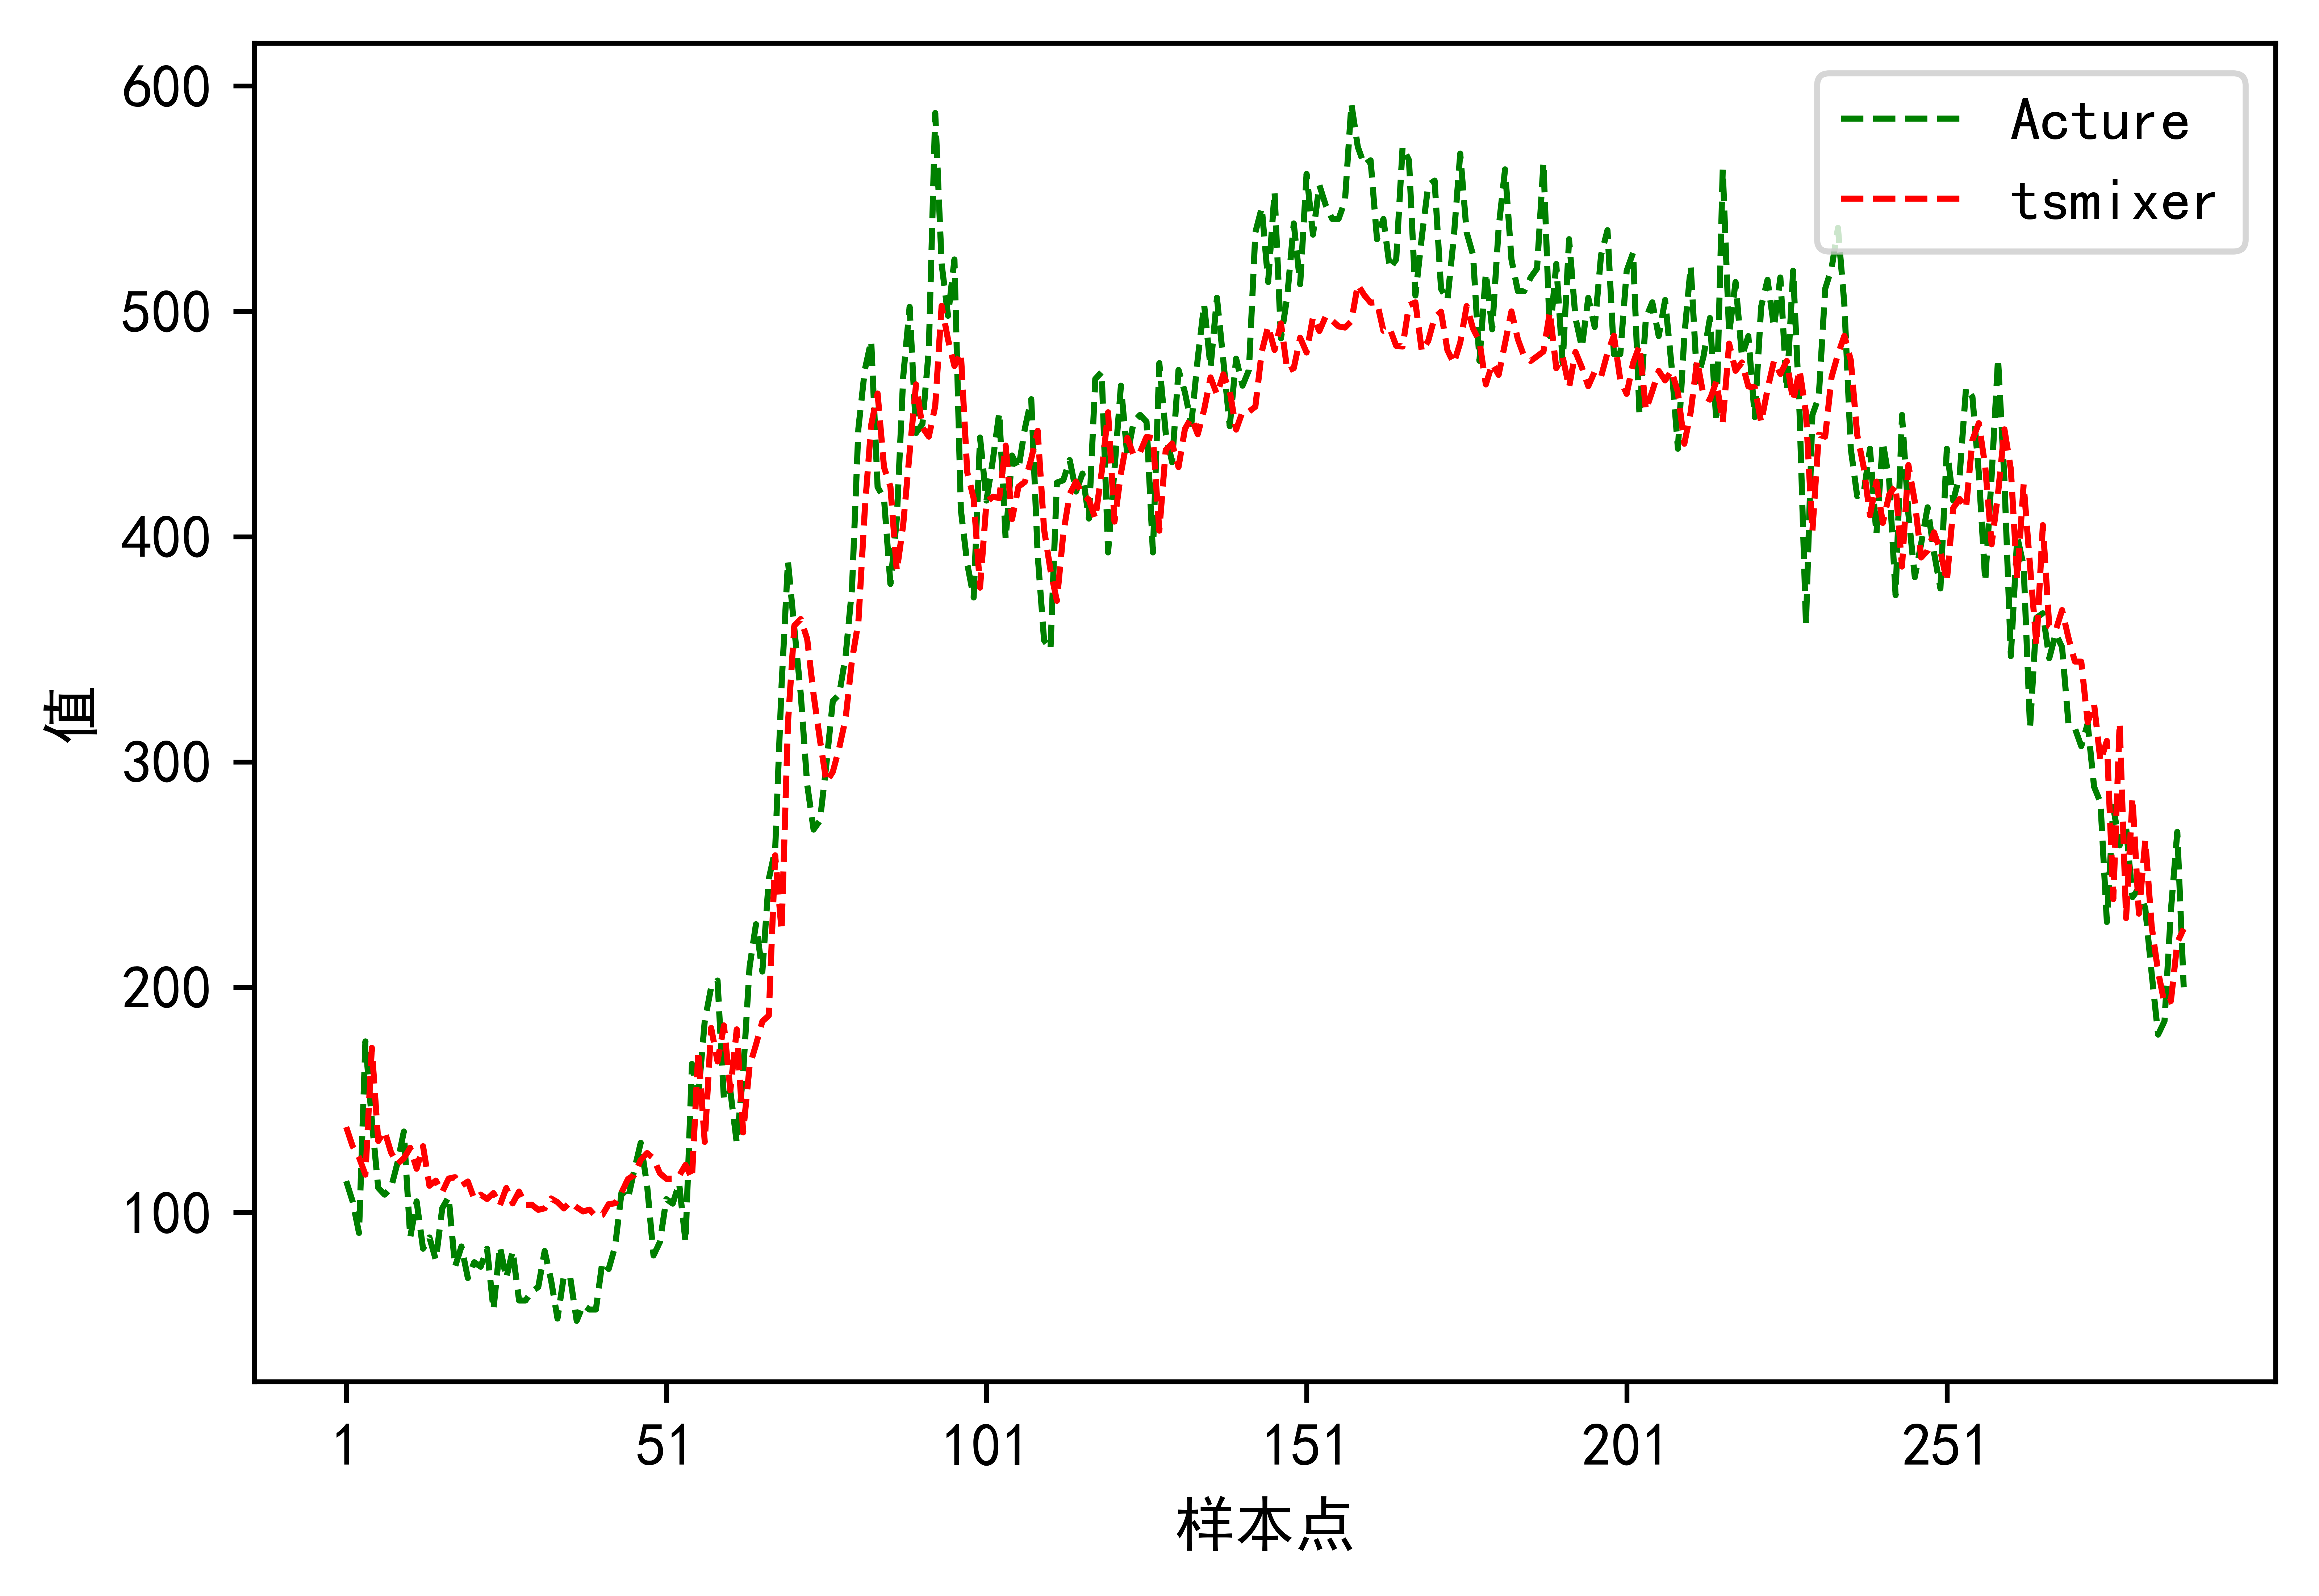

In [16]:
# 测试集
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000  # Increase the value to an appropriate number

import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(mean_pre_test) + 1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, mean_actual_test, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, mean_pre_test,  color='red',linestyle="--",linewidth=1,label='tsmixer')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("值",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('1.png')
plt.show()

In [17]:
#保存预测结果
# savemat('结果/vmd_pso_elm_result.mat',{'true':inv_y,'pred':inv_yhat})
savemat('结果/tsmixer_result.mat',{'true':mean_actual_test,'pred':mean_pre_test})